In [1]:
import models
import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'
learning_rate = 0.0001
iterations = 50e3 
batch_size = 2
val_freq = 5000
net = models.layers.PCRCN().cuda()
criterion_l1 = nn.L1Loss()
optimizer = torch.optim.Adam(net.parameters(),lr = learning_rate,betas=(0.5,0.999))
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
#                     milestones=[10e3,20e3,30e3], gamma=0.5)
train_dataset = datasets.webface_data.Webface_landmarks68()
test_dataset = datasets.helen_data.Helen()

/home/zelin/anaconda3/envs/GFPGAN/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('./logger')
train_data = DataLoader(train_dataset,batch_size = batch_size,shuffle=True,num_workers=8)
test_data = DataLoader(test_dataset,batch_size=2,shuffle=False)

2023-04-03 14:55:14.591164: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-03 14:55:15.301288: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/zelin/anaconda3/envs/GFPGAN/lib/python3.7/site-packages/cv2/../../lib64:
2023-04-03 14:55:15.301359: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/zelin/anaconda3/envs/GFPGAN/lib/pytho

In [3]:
for i,data in enumerate(train_data):
    optimizer.zero_grad()
    lr,hr,lm = data
    lr = lr.float().cuda()
    hr = hr.float().cuda()
    lm = lm.float().cuda()
    break

In [4]:
_2x_sr,_4x_sr,_8x_sr,_4x_par,_8x_par = net(lr)

In [8]:
_2x_sr.shape

torch.Size([2, 3, 48, 48])

In [4]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('./logger')
train_data = DataLoader(train_dataset,batch_size = batch_size,shuffle=True,num_workers=8)
test_data = DataLoader(test_dataset,batch_size=2,shuffle=False)
step = 0
iterations = 10e4 
with tqdm(total=iterations) as pbar:
    while step<iterations:
        for i,data in enumerate(train_data):
            optimizer.zero_grad()
            lr_24,lr_48,lr_96,hr,lm = data
            lr_24 = lr_24.float().cuda()
            lr_48 = lr_48.float().cuda()
            lr_96 = lr_96.float().cuda()
            hr = hr.float().cuda()
            lm = lm.float().cuda()
            _2x_sr,_4x_sr,_8x_sr,_4x_par,_8x_par = net(lr_24)
            loss_2x = criterion_l1(_2x_sr,lr_48)
            
            loss_4x = 0
            for _4x in _4x_sr:
                loss_4x += criterion_l1(_4x,lr_96)
            loss_4x /= 4 

            loss_8x = 0
            for _8x in _8x_sr:
                loss_8x += criterion_l1(_8x,hr)
            loss_8x /= 4 

            loss_4x_par = 0
            for _4x_p in _4x_par:
                loss_4x_par += criterion_l1(F.interpolate(_4x_p,(512,512)),lm)
            loss_4x_par /= 4

            loss_8x_par = 0
            for _8x_p in _8x_par:
                loss_8x_par += criterion_l1(F.interpolate(_8x_p,(512,512)),lm)
            loss_8x_par /= 4

            loss = loss_2x + loss_4x + 5*loss_8x + 0.01*(loss_4x_par+loss_8x_par)
            loss.backward()
            optimizer.step()
            step+=1
            # scheduler.step()
            # pbar.set_description('')
            pbar.update(1)
            writer.add_scalar('2x',loss_2x, global_step=step, walltime=None)
            writer.add_scalar('4x',loss_4x, global_step=step, walltime=None)
            writer.add_scalar('8x',loss_8x, global_step=step, walltime=None)
            writer.add_scalar('4x_par',loss_4x_par, global_step=step, walltime=None)
            writer.add_scalar('8x_par',loss_8x_par, global_step=step, walltime=None)
            if step%val_freq == 0:
                psnr = 0
                for j,test_ in enumerate(test_data):
                    net.eval()
                    lr_24,hr = test_
                    lr_24 = lr_24.float().cuda()
                    hr = hr.float().cuda()
                    with torch.no_grad():
                        _2x_sr,_4x_sr,_8x_sr,_4x_par,_8x_par = net(lr_24)
                        mse = ((_8x_sr[-1]-hr)**2).mean(dim=[1,2,3])
                        psnr += (10*torch.log10(1/mse)).mean()
                net.train()
                writer.add_scalar('val_psnr',psnr/len(test_data), global_step=step, walltime=None)
                torch.save(net.state_dict(), '/home/zelin/csrnet/Baseline/PCRCN/checkpoints/rcnet_%06d.pt'%step)
                writer.add_images('sr', _8x_sr[-1], global_step=step, walltime=None, dataformats='NCHW')
            if step==iterations:
                break

100%|██████████| 100000/100000.0 [10:15:45<00:00,  2.71it/s]  


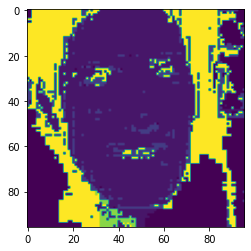

In [5]:
from matplotlib import pyplot as plt
plt.imshow(_8x_par[-1][0].argmax(0).detach().cpu().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


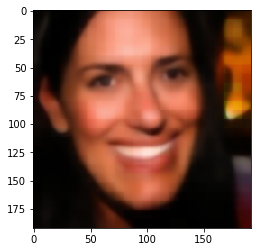

In [6]:
from matplotlib import pyplot as plt
plt.imshow(_8x_sr[-1][0].permute(1,2,0).detach().cpu().numpy())

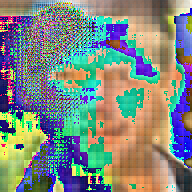

In [27]:
import torchvision.transforms as transforms
transforms.ToPILImage()(_8x_sr[1].sum(0))

In [22]:
lm[0].sum(0)

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0')

In [7]:
_8x_sr[-1][0].shape

torch.Size([3, 192, 192])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


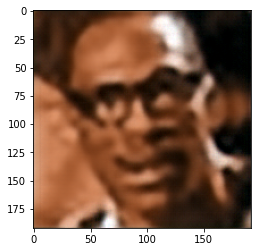

In [ ]:
plt.imshow(coarse_sr[-1][1].permute(1,2,0).detach().cpu().numpy())